In [1]:
import numpy as np
import gym
from keras import losses
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


**REINFORCE Agent**

In [2]:
class ReinforceAgent:
    def __init__(self,env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.size_of_state = self.observation_space.shape[0]
        self.number_of_actions = self.action_space.n
        
        self.memory = deque(maxlen=1000)
        self.gamma = 0.99
        self.alpha = 0.0001
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.size_of_state, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(self.number_of_actions, activation='softmax'))
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.01))
        return model

    def step(self, state):
        theta_values = np.array(self.model.predict(state)[0])
        normalized_theta_values = theta_values/(np.sum(theta_values))
        action = np.random.choice(self.number_of_actions, 1, p=normalized_theta_values)[0]
        return action, normalized_theta_values

    def modify_policy_weights(self):
        states, actions, rewards, thetas, deltas = [],[],[],[],[]    
        for state, action, reward,theta in self.memory:  
            states.append(state)
            action_states = np.zeros(self.number_of_actions)
            action_states[action] = 1
            actions.append(action_states)
            deltas.append(action_states-theta)
            rewards.append(reward)
            thetas.append(theta)

        states = np.array(states)
        states = states.reshape(states.shape[0],states.shape[2])
        # print("states: ", states)       
        # print("actions: ", actions)
        # print("rewards: ", rewards)
        # print("thetas: ", thetas)
        # print("deltas: ", deltas)
        gamma_Gt = []
        total_rewards = 0
        for reward in rewards[::-1]:
            total_rewards = total_rewards*self.gamma + reward
            gamma_Gt.insert(0, total_rewards)
        gamma_Gt = np.round(np.array(gamma_Gt),4)

        # Standardize rewards return
        mean_gamma_Gt = np.mean(gamma_Gt)
        std_gammat_Gt = np.std(gamma_Gt)
        gamma_Gt = (gamma_Gt-mean_gamma_Gt)/(std_gammat_Gt + 1e-7)

        # print("gamma_Gt: ", gamma_Gt)
        alpha_gamma_Gt = self.alpha * gamma_Gt      
        alpha_gamma_Gt = alpha_gamma_Gt.reshape(alpha_gamma_Gt.shape[0],1)
        # print("alpha_gamma_Gt: ",alpha_gamma_Gt)

        alpha_gamma_Gt_deltas = alpha_gamma_Gt*deltas
        # print("alpha_gamma_Gt_deltas: ",alpha_gamma_Gt_deltas)
       
        thetas_new = thetas + alpha_gamma_Gt_deltas
        # print("thetas_new: ",thetas_new)

        self.model.train_on_batch(states,thetas_new)
        self.memory.clear()

**CartPole Environment**

In [3]:
class Environment:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.reinforceAgent = ReinforceAgent(self.env)
        self.number_of_episodes = 500
        self.C = 1
        self.rewards_history = []
        self.average_rewards_history = []
        self.reward_average_episodes = 10

    def train(self):
        for episode in range(self.number_of_episodes):
            state = self.env.reset()
            state = state.reshape(1,state.shape[0])

            done = False
            episode_reward = 0
            while not done:
                action, theta = self.reinforceAgent.step(state)
                state_prime, reward, done, info = self.env.step(action)
                state_prime = state_prime.reshape(1, state_prime.shape[0])
                self.reinforceAgent.memory.append([state, action,reward,theta])
                state = state_prime
                episode_reward += reward

            self.rewards_history.append(episode_reward)
            if episode > self.reward_average_episodes:
                self.average_rewards_history.append(sum(self.rewards_history[-self.reward_average_episodes:])/self.reward_average_episodes)

            print("Episode: {}, reward: {}".format(episode, episode_reward))
            if episode % self.C == 0:
                self.reinforceAgent.modify_policy_weights()


In [4]:
env = Environment()
env.train()

Episode: 0, reward: 19.0
Episode: 1, reward: 17.0
Episode: 2, reward: 17.0
Episode: 3, reward: 14.0
Episode: 4, reward: 21.0
Episode: 5, reward: 18.0
Episode: 6, reward: 30.0
Episode: 7, reward: 18.0
Episode: 8, reward: 18.0
Episode: 9, reward: 15.0
Episode: 10, reward: 18.0
Episode: 11, reward: 25.0
Episode: 12, reward: 32.0
Episode: 13, reward: 29.0
Episode: 14, reward: 30.0
Episode: 15, reward: 21.0
Episode: 16, reward: 27.0
Episode: 17, reward: 47.0
Episode: 18, reward: 24.0
Episode: 19, reward: 79.0
Episode: 20, reward: 28.0
Episode: 21, reward: 43.0
Episode: 22, reward: 31.0
Episode: 23, reward: 36.0
Episode: 24, reward: 19.0
Episode: 25, reward: 29.0
Episode: 26, reward: 91.0
Episode: 27, reward: 35.0
Episode: 28, reward: 79.0
Episode: 29, reward: 51.0
Episode: 30, reward: 43.0
Episode: 31, reward: 62.0
Episode: 32, reward: 11.0
Episode: 33, reward: 115.0
Episode: 34, reward: 37.0
Episode: 35, reward: 52.0
Episode: 36, reward: 25.0
Episode: 37, reward: 37.0
Episode: 38, reward: 

**Game score and average score graphs**

Game score:  [19.0, 17.0, 17.0, 14.0, 21.0, 18.0, 30.0, 18.0, 18.0, 15.0, 18.0, 25.0, 32.0, 29.0, 30.0, 21.0, 27.0, 47.0, 24.0, 79.0, 28.0, 43.0, 31.0, 36.0, 19.0, 29.0, 91.0, 35.0, 79.0, 51.0, 43.0, 62.0, 11.0, 115.0, 37.0, 52.0, 25.0, 37.0, 22.0, 16.0, 37.0, 18.0, 54.0, 40.0, 23.0, 34.0, 109.0, 30.0, 69.0, 22.0, 65.0, 33.0, 55.0, 45.0, 61.0, 49.0, 56.0, 35.0, 91.0, 18.0, 125.0, 36.0, 105.0, 122.0, 96.0, 96.0, 126.0, 58.0, 106.0, 227.0, 53.0, 81.0, 80.0, 72.0, 118.0, 183.0, 95.0, 108.0, 162.0, 144.0, 214.0, 120.0, 195.0, 260.0, 253.0, 211.0, 138.0, 148.0, 297.0, 205.0, 185.0, 126.0, 154.0, 130.0, 116.0, 142.0, 126.0, 168.0, 110.0, 78.0, 56.0, 142.0, 111.0, 157.0, 78.0, 115.0, 159.0, 169.0, 193.0, 313.0, 302.0, 234.0, 205.0, 471.0, 305.0, 291.0, 401.0, 162.0, 500.0, 462.0, 500.0, 290.0, 500.0, 500.0, 169.0, 108.0, 500.0, 500.0, 392.0, 500.0, 500.0, 297.0, 379.0, 260.0, 236.0, 191.0, 153.0, 132.0, 111.0, 119.0, 131.0, 117.0, 230.0, 232.0, 94.0, 281.0, 320.0, 203.0, 224.0, 200.0, 202.0, 

[Text(0, 0.5, 'Average Game score')]

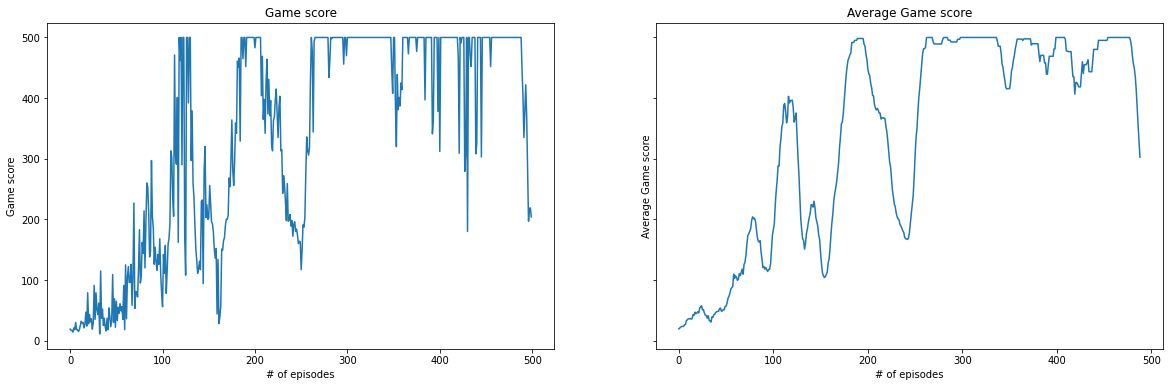

In [5]:
print("Game score: ", env.rewards_history)
print("Average Game score: ", env.average_rewards_history)
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axs[0].plot(np.arange(len(env.rewards_history)), env.rewards_history)
axs[0].set_title('Game score')
axs[0].set(xlabel = "# of episodes")
axs[0].set(ylabel = "Game score")
axs[1].plot(np.arange(len(env.average_rewards_history)), env.average_rewards_history)
axs[1].set_title('Average Game score')
axs[1].set(xlabel = "# of episodes")
axs[1].set(ylabel = "Average Game score")
